In [63]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

# Modeling using Word Embedding

In [148]:
# for handling emojis
import demoji


In [149]:
datapath = '../data/interim/'

In [150]:
train_df = pd.read_csv(datapath + 'interim_train_df.csv')

In [151]:
train_df.head()

,text,Disaster
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [152]:
test_df = pd.read_csv(datapath + 'interim_test_df.csv')
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


## Text Preprocessing

In [153]:
lst_stopwords = stopwords.words("english")

In [154]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords):
    ## clean (convert to lowercase. remove punctuations, urls, mentions,  tags, and digits)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r"http\S+", "", text) #remove urls
    text = re.sub('#[^\s]+','', text) #remove hashtags
    text = re.sub('@[^\s]+','', text) #remove tags
    text = re.sub(r'[0-9]+','', text) #remove digits
    text = demoji.replace(text, '') #remove emoijis

            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        whitelist = ["n't", "not", "no"]
        lst_text = [word for word in lst_text if (word not in lst_stopwords or word in whitelist) and len(word) > 1]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text


In [155]:
train_df['text'] = train_df['text'].apply(utils_preprocess_text)

In [156]:
(train_df.text == "" ).sum() # check for empty tweets after preprocessing

0

In [157]:
test_df["text"] = test_df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
test_df.head()

,text
0,happened terrible car crash
1,heard earthquake different city stay safe ever...
2,forest fire spot pond goose fleeing across str...
3,apocalypse lighting spokane wildfire
4,typhoon soudelor kill china taiwan


## Split the data into training and testing sets

In [158]:

X_train, X_test, y_train, y_test = train_test_split(train_df.text, train_df.Disaster, test_size=0.1, random_state=37, stratify=train_df.Disaster)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 6851
# Test data samples: 762


In [159]:
X_train

7379     texas seek comment rule change windstorm insurer
6663                          warned expected threat soul
5544    due rainstorm last night cupcake decorating ha...
167     statistically im risk getting killed cop dying...
1133    cryptic word guided pilot hiroshima bombing mi...
                              ...                        
5166                                  time obliterate sin
2879    moderate drought spreading rapidly across cent...
5081    beforeitsnews former executive prosecuted fuku...
786        get load welfare loving spongea blight society
2319    take china get demolished sent back fucking st...
Name: text, Length: 6851, dtype: object

### The number of words and sequence length in the training corpus
This will be used for the neural network model in Keras.

In [160]:
word_counts = X_train.str.split(expand=True).stack().value_counts().reset_index()
word_counts.columns = ['word', 'count']

In [161]:
word_counts.head()

,word,count
0,fire,314
1,like,312
2,amp,270
3,im,268
4,not,263


In [162]:
print('The number of words in the training corpus is: ', word_counts.shape[0])

The number of words in the training corpus is:  14774


In [163]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    6851.000000
mean        9.180850
std         3.520844
min         1.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        23.000000
Name: text, dtype: float64

# Train a Deep Learning Model

In [164]:
# Source: https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Using%20Word%20Embeddings%20for%20Sentiment%20Analysis.ipynb

In [165]:
NB_WORDS = 14774  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 23  # Maximum number of words in a sequence
#GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [166]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train the model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='adam'
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

### Words Tokenization

In [167]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 6851 documents
14774 words in dictionary
Top 5 most common words are: [('fire', 314), ('like', 312), ('amp', 270), ('im', 269), ('not', 263)]


In [171]:
X_train_seq[3]

[5535, 4, 766, 143, 57, 812, 1406, 295, 62]

### Let's check what is the 'amp' token

In [179]:
train_df[train_df.text.str.contains(' amp ')].head()

,text,Disaster
62,rene ablaze amp jacinta secret fallen sky edit...,0
64,nowplaying rene ablaze amp ian buff magnitude edm,0
67,cant kid cuz got bicycle accident amp split te...,0
70,personalinjury accident summer read advice amp...,0
171,early wake call sister begging come amp ride w...,1


In [170]:
# Check the original tweet
df = pd.read_csv(datapath + 'interim_train_df.csv')

In [178]:
df.iloc[171].to_list()

['Early wake up call from my sister begging me to come over &amp; ride w/her in the ambulance to the hospital #RODKiai',
 1]

- 'amp' is the preprocessed form of '&amp:' which is &

## Adjust the word sequences to an equal length

In [182]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [183]:
X_train_seq_trunc[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1297,  598,   59,   41,  403,  428,
        504], dtype=int32)

In [184]:
print('The lenght of word sequences is adjusted to be = ', len(X_train_seq_trunc[10]))

The lenght of word sequences is adjusted to be =  23


### Prepare a Validation set 

In [186]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train, test_size=0.1, random_state=42, stratify=y_train)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:', X_valid_emb.shape)

Shape of validation set: (686, 23)


## Experiment -1: Build a simple Neural Network based on the Generated Word Embedding

In [187]:
# one node in the output
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(1, activation='sigmoid'))
emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 8)             118192    
_________________________________________________________________
flatten (Flatten)            (None, 184)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 185       
Total params: 118,377
Trainable params: 118,377
Non-trainable params: 0
_________________________________________________________________


In [197]:
X_train_emb.shape, y_train_emb.shape

((6165, 23), (6165,))

In [198]:
X_valid_emb.shape, y_valid_emb.shape

((686, 23), (686,))

In [192]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [193]:
emb_history.history['accuracy'][-1]

0.8115166425704956

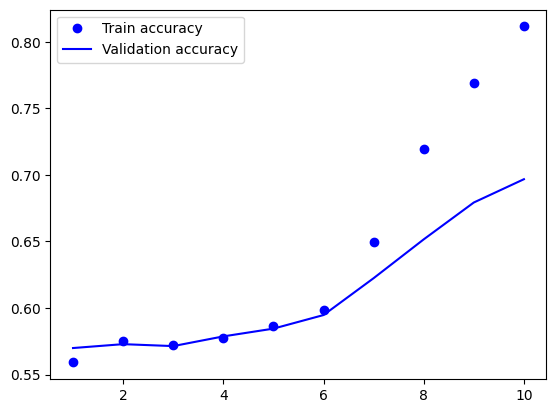

In [194]:
eval_metric(emb_history, 'accuracy')


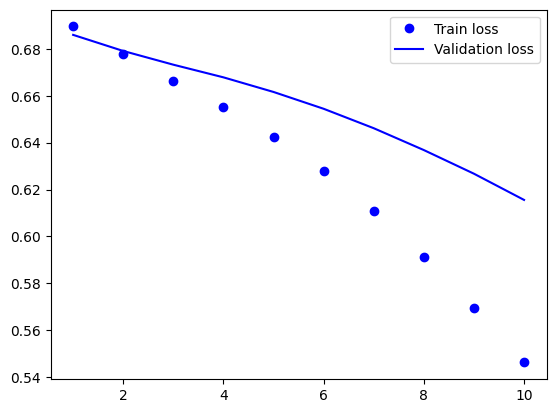

In [195]:
eval_metric(emb_history, 'loss')

In [278]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 10)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 868us/step - loss: 0.5029 - accuracy: 0.7703
/n
Test accuracy of word embeddings model: 77.03%


In [279]:
y_pred = emb_model.predict(X_test_seq_trunc)
y_pred =( y_pred > 0.5).astype('int32')

In [280]:
from sklearn.metrics import classification_report, confusion_matrix


In [281]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[373  62]
 [113 214]]


In [282]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.86      0.81       435
           1       0.78      0.65      0.71       327

    accuracy                           0.77       762
   macro avg       0.77      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



## Experiment -2: Adding layer and increasing the output dimension of the embedding layer to 32

In [246]:
# one node in the output
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NB_WORDS, 32, input_length=MAX_LEN))
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(17, activation='relu'))
emb_model2.add(layers.Dense(1, activation='sigmoid'))

emb_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 32)            472768    
_________________________________________________________________
flatten_2 (Flatten)          (None, 736)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 17)                12529     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 18        
Total params: 485,315
Trainable params: 485,315
Non-trainable params: 0
_________________________________________________________________


In [247]:
emb_history2 = deep_model(emb_model2, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [248]:
emb_history2.history['accuracy'][-1]

0.9792376160621643

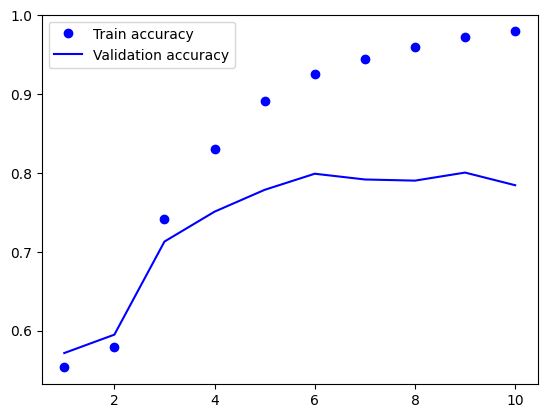

In [249]:
eval_metric(emb_history2, 'accuracy')


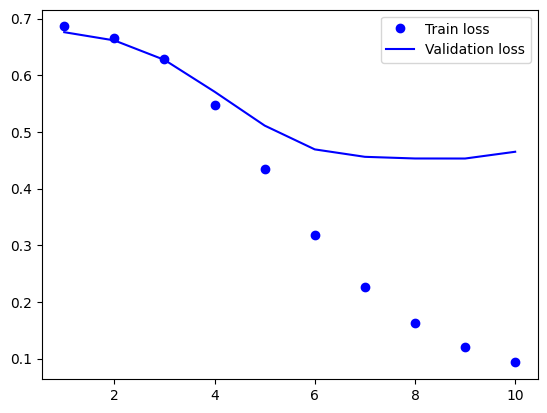

In [250]:
eval_metric(emb_history2, 'loss')

In [251]:
emb_results = test_model(emb_model2, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 1ms/step - loss: 0.5623 - accuracy: 0.7808
/n
Test accuracy of word embeddings model: 78.08%


In [252]:
y_pred = emb_model2.predict(X_test_seq_trunc)
y_pred =( y_pred > 0.5).astype('int32')

In [253]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[373  62]
 [105 222]]


In [245]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.84      0.81       435
           1       0.76      0.67      0.71       327

    accuracy                           0.77       762
   macro avg       0.77      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



In [69]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 184)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 370       
Total params: 80,370
Trainable params: 80,370
Non-trainable params: 0
_________________________________________________________________


In [73]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (686, 23)


In [75]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history.history['accuracy'][-1]

0.8945661187171936

In [76]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 897us/step - loss: 0.4967 - accuracy: 0.7677
/n
Test accuracy of word embeddings model: 76.77%


## Experiment -3: Using Recurrent Neural Network with LSTM with Dropout

In [255]:
# one node in the output
emb_model3 = models.Sequential()
emb_model3.add(layers.Embedding(NB_WORDS, 32, input_length=MAX_LEN))
emb_model3.add(layers.LSTM(60, dropout=0.1))
emb_model3.add(layers.Dense(1, activation='sigmoid'))

emb_model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 23, 32)            472768    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                22320     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 61        
Total params: 495,149
Trainable params: 495,149
Non-trainable params: 0
_________________________________________________________________


In [256]:
emb_history3 = deep_model(emb_model3, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [257]:
emb_history2.history['accuracy'][-1]

0.9792376160621643

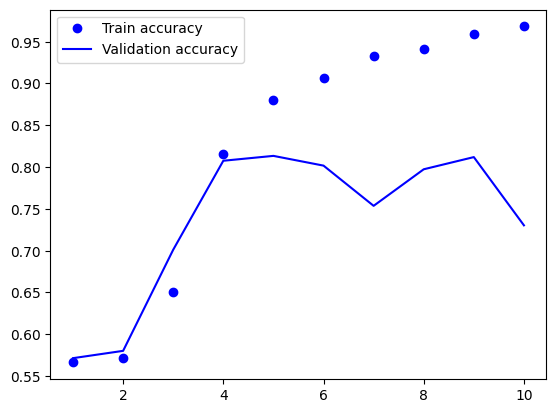

In [258]:
eval_metric(emb_history3, 'accuracy')


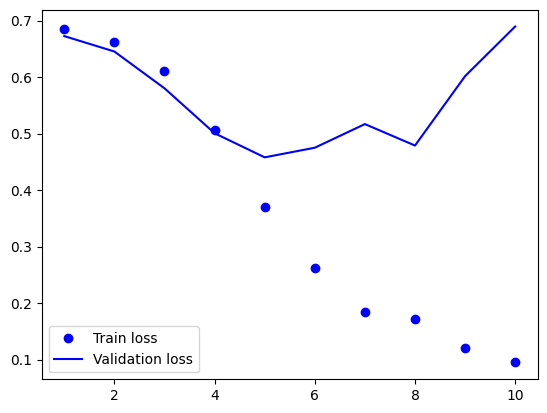

In [259]:
eval_metric(emb_history3, 'loss')

In [261]:
emb_results = test_model(emb_model3, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 5)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 4ms/step - loss: 1.0211 - accuracy: 0.7703
/n
Test accuracy of word embeddings model: 77.03%


In [262]:
y_pred = emb_model3.predict(X_test_seq_trunc)
y_pred =( y_pred > 0.5).astype('int32')

In [263]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[370  65]
 [110 217]]


In [264]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.85      0.81       435
           1       0.77      0.66      0.71       327

    accuracy                           0.77       762
   macro avg       0.77      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



In [75]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history.history['accuracy'][-1]

0.8945661187171936

In [76]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 897us/step - loss: 0.4967 - accuracy: 0.7677
/n
Test accuracy of word embeddings model: 76.77%


## Experiment -4: Using Pre-trained Model (transfer learning)

In [128]:
input_path = '../models/glove.twitter.27B/glove.twitter.27B.100d.txt'


In [129]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(input_path)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()